## Getting started

次に、以下の" "の間に、githubからダウンロードしたフォルダのパスを指定する。

In [6]:
import os
# 現在のディレクトリのパスを取得
current_directory = os.getcwd()
# 現在のディレクトリの2つ上の階層のパスを取得
dir = os.path.dirname(current_directory)

import warnings

warnings.filterwarnings("ignore", message="Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.")

import numpy as np
import pandas as pd
import copy
import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict

###
from jie import aligner
from jie import plot

###
# Multiprocessing
import multiprocessing.pool as mpp
from multiprocessing.pool import ThreadPool as Pool

# from https://stackoverflow.com/questions/57354700/starmap-combined-with-tqdm
# Author: Darkonaut (08/05/2019)

def istarmap(self, func, iterable, chunksize=1):
    """starmap-version of imap
    """
    self._check_running()
    if chunksize < 1:
        raise ValueError(
            "Chunksize must be 1+, not {0:n}".format(
                chunksize))

    task_batches = mpp.Pool._get_tasks(func, iterable, chunksize)
    result = mpp.IMapIterator(self)
    self._taskqueue.put(
        (
            self._guarded_task_generation(result._job,
                                          mpp.starmapstar,
                                          task_batches),
            result._set_length
        ))
    return (item for chunk in result for item in chunk)

mpp.Pool.istarmap = istarmap

from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans

### Reference genome
- Next, we build a __reference table of genomic distances__ (`df_refgen`) that separate imaged probes.
    - This is critical for us to estimate an __expected spatial distance__, to which we compare the __observed spatial distance__ separating two imaged loci.
<br></br>
- Of note, this probe set is reused to image the mouse brain cortex (Takei _et al., Science_ __374__, 586-596 (2021))
    - Theses coordinates below correspond to this current (Nature) work's [Supplementary Table 1](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-03126-2/MediaObjects/41586_2020_3126_MOESM2_ESM.xlsx)

In [7]:
df = pd.read_csv(os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-coords.csv"))

# find genomic distance between each bin 
df_list = []

# for every chromosome
for chrom, group in df.groupby('Chrom'):
    
    # find genomic distance relative to preceding bin
    _df = copy.deepcopy(group)
    
    # sort by start
    _df.sort_values(by='Start', inplace = True)
    
    # record relative region ID (relative to chrom start site)
    _df['hyb'] = [i for i in range(_df.shape[0])]
    
    # calculate genomic distance relative to first starting position
    _df['delta'] = _df['Start'] - _df['Start'].iloc[0]
            
    df_list.append(_df)

# merge all dataframes
df_refgen = pd.concat(df_list)

df_refgen

,Region ID,Name,Channel,Chrom,Start,End,Chrom ID,hyb,delta
52,1,Nanog_assoc#1,3,chr6,94672506,94707506,6,0,0
73,2,Non_Nanog_assoc#1,2,chr6,95937507,95962506,6,1,1265001
53,3,Nanog_assoc#2,3,chr6,97192506,97217506,6,2,2520000
54,4,Nanog_assoc#3,1,chr6,97932506,97967506,6,3,3260000
41,5,Foxp1,2,chr6,99031960,99056959,6,4,4359454
...,...,...,...,...,...,...,...,...,...
37,116,Ergic2,2,chr6,148184029,148209028,6,115,53511523
105,117,Rps4l,1,chr6,148342157,148367156,6,116,53669651
28,118,Caprin2,2,chr6,148878328,148903327,6,117,54205822
71,119,Nanog_assoc#20,3,chr6,148973978,148998978,6,118,54301472


### Candidate spatial coordinates
- We load decoded spatial coordinates of imaged genomic loci as a table (`df_seqfish`).

In [8]:
### HELPER FXN ###
def map_to_hyb(gene_name):
    return geneID_to_hyb[gene_name]

def map_to_chrom(gene_name):
    return geneID_to_chrom[gene_name]

# create lookup table for hyb
geneID_to_hyb = {name:hyb for name, hyb in zip(df_refgen['Name'], df_refgen['hyb'])}

# create lookup table for chrom
geneID_to_chrom = {name:chrom for name, chrom in zip(df_refgen['Name'], df_refgen['Chrom'])}


df_list = pd.read_csv(os.path.join(dir, "X1_accessory_data", "seq_DNA-FISH_before_correction_rep1.csv"))
df_list['replicate'] = 'replicate1'


# merge all dataframes
# df_seqfish = pd.concat(df_list)
df_seqfish = df_list

# assign cell type
df_seqfish['celltype'] = ['mesc',] * df_seqfish.shape[0]

# record hyb
df_seqfish['hyb'] = df_seqfish['geneID'].apply(lambda x: map_to_hyb(x))

# if min(df_seqfish['hyb'].values) 


# record chrom
df_seqfish['chr'] = df_seqfish['geneID'].apply(lambda x: map_to_chrom(x))

# adjust Z resolution
# df_seqfish['z'] = df_seqfish['z'] * 250/103

# add dummy localization error
df_seqfish['sig_z'] = [1, ] * df_seqfish.shape[0]
df_seqfish['sig_y'] = [1, ] * df_seqfish.shape[0]
df_seqfish['sig_x'] = [1, ] * df_seqfish.shape[0]

# rename columns
df_seqfish.rename(columns = {'z':'z_hat', 'y':'y_hat', 'x':'x_hat', 
                                'fov':'FOV', 'cellID':'cell', 'rep':'replicate'}, inplace = True)

# assign unique cell ID
df_seqfish['finalcellID'] = df_seqfish.groupby(['FOV', 'replicate', 'cell']).ngroup()

df_seqfish

,FOV,cell,channel,geneID,x_hat,y_hat,z_hat,Stack_ID,spot_intensity,norm_spot_intensity,...,nuc_volume,nuc_mean_intensity,replicate,celltype,hyb,chr,sig_z,sig_y,sig_x,finalcellID
0,1,4,1,Setd5,602.004045,202.315497,44.938063,ND40_C1_TyD,915,8.394495,...,616354,2910.2644,replicate1,mesc,22,chr6,1,1,1,0
1,1,5,1,Setd5,244.898024,303.353942,35.925950,ND40_C1_TyD,1693,15.532110,...,469161,3427.5210,replicate1,mesc,22,chr6,1,1,1,1
2,1,6,1,Setd5,650.855126,597.318923,36.524970,ND40_C1_TyD,983,9.018349,...,631504,3573.0745,replicate1,mesc,22,chr6,1,1,1,2
3,1,8,1,Setd5,133.011056,826.507837,54.424640,ND40_C1_TyD,612,5.614679,...,620413,2828.1360,replicate1,mesc,22,chr6,1,1,1,3
4,1,8,1,Setd5,118.014858,886.269721,55.982392,ND40_C1_TyD,657,6.027523,...,620413,2828.1360,replicate1,mesc,22,chr6,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152806,30,4,2,Non_Nanog_assoc#5,312.687456,644.150804,24.171542,ND36_C2_TyD,1449,8.327586,...,355474,2246.9402,replicate1,mesc,10,chr6,1,1,1,652
152807,30,4,2,Non_Nanog_assoc#5,327.090815,586.603761,25.117259,ND36_C2_TyD,1358,7.804598,...,355474,2246.9402,replicate1,mesc,10,chr6,1,1,1,652
152808,30,11,2,Non_Nanog_assoc#5,370.994679,307.629205,28.404009,ND36_C2_TyD,1181,6.787356,...,378137,2881.9404,replicate1,mesc,10,chr6,1,1,1,657
152809,30,20,2,Non_Nanog_assoc#5,418.229572,757.491857,41.012262,ND36_C2_TyD,1399,8.040230,...,286841,3112.5044,replicate1,mesc,10,chr6,1,1,1,666


In [9]:
# ここで、1細胞あたりの輝点数が異様に少ないものは排除する。

a = pd.DataFrame()

cell_list = list(set(df_seqfish.finalcellID.values))

for i in cell_list:
    b = df_seqfish.loc[df_seqfish['finalcellID']==i,]
    if len(b)>100:
        a = pd.concat([a,b])

print('cell no : ',len(list(set(a.finalcellID.values))))

df_seqfish = a.copy()

cell no :  645


- This can be subsetted into spatial coordinates by 
    - `chr`
    - `FOV`
    - `replicate`
    - `cell`
<br></br>    

- NB: A previous implementation provided a class `Cell` whose attributes store metadata and spatial coordinates.
    - This was difficult to subset (ie. find all `Cell` instances with `chr == 'chr3'` and `FOV == '2'`). 
    - In this vignette, we store sets of coordinates in a DataFrame __`chr_pts`__ that allows quick subsetting. 
        - The column `data` is itself a list of `DataFrames`.
        - If you have a better database solution, __please submit an enhancement inquiry__ on Github!

In [10]:
# save results
chr_pts = {'replicate': {},
           'FOV': {},
           'cell': {},
           'finalcellID': {},
           'celltype': {},
           'chr': {},
           'data': {}}

# group by celltype, chr, finalcellD
for i, (name, group) in enumerate(df_seqfish.groupby(by=['celltype', 'chr', 'finalcellID'])):
            
    # make copy
    _df_cell = copy.deepcopy(group)
    
    # drop columns
    _df_cell = _df_cell[['replicate', 'FOV', 'cell', 'finalcellID',  
                         'celltype','chr', 'hyb', 'geneID', 
                         'x_hat', 'y_hat', 'z_hat', 
                         'sig_x', 'sig_y', 'sig_z']]

    # sort by hyb_rnd
    _df_cell = _df_cell.sort_values(by=['hyb'])

    # reset index
    _df_cell.reset_index(inplace=True, drop = True)

    # save df
    chr_pts['replicate'][i] = _df_cell.iloc[0]['replicate']
    chr_pts['FOV'][i] = _df_cell.iloc[0]['FOV']
    chr_pts['cell'][i] = _df_cell.iloc[0]['cell']
    chr_pts['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
    chr_pts['celltype'][i] = _df_cell.iloc[0]['celltype']
    chr_pts['chr'][i] = _df_cell.iloc[0]['chr']
    chr_pts['data'][i] = _df_cell
            
chr_pts = pd.DataFrame(chr_pts)
chr_pts

,replicate,FOV,cell,finalcellID,celltype,chr,data
0,replicate1,1,4,0,mesc,chr6,replicate FOV cell finalcellID cellty...
1,replicate1,1,5,1,mesc,chr6,replicate FOV cell finalcellID cellty...
2,replicate1,1,6,2,mesc,chr6,replicate FOV cell finalcellID cellty...
3,replicate1,1,8,3,mesc,chr6,replicate FOV cell finalcellID cellty...
4,replicate1,1,10,4,mesc,chr6,replicate FOV cell finalcellID cellty...
...,...,...,...,...,...,...,...
640,replicate1,30,23,669,mesc,chr6,replicate FOV cell finalcellID cellty...
641,replicate1,30,25,670,mesc,chr6,replicate FOV cell finalcellID cellty...
642,replicate1,30,26,671,mesc,chr6,replicate FOV cell finalcellID cellty...
643,replicate1,30,28,672,mesc,chr6,replicate FOV cell finalcellID cellty...


In [11]:
chr_pts.loc[0,'data']

,replicate,FOV,cell,finalcellID,celltype,chr,hyb,geneID,x_hat,y_hat,z_hat,sig_x,sig_y,sig_z
0,replicate1,1,4,0,mesc,chr6,0,Nanog_assoc#1,604.302780,196.663349,47.357128,1,1,1
1,replicate1,1,4,0,mesc,chr6,0,Nanog_assoc#1,561.091077,207.518547,30.165820,1,1,1
2,replicate1,1,4,0,mesc,chr6,1,Non_Nanog_assoc#1,563.935066,210.304803,31.763496,1,1,1
3,replicate1,1,4,0,mesc,chr6,1,Non_Nanog_assoc#1,604.791725,197.691990,49.094458,1,1,1
4,replicate1,1,4,0,mesc,chr6,2,Nanog_assoc#2,605.018879,199.371898,47.959586,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,replicate1,1,4,0,mesc,chr6,114,Mrps35,549.379616,208.578609,32.401922,1,1,1
236,replicate1,1,4,0,mesc,chr6,114,Mrps35,613.299272,216.646204,48.291923,1,1,1
237,replicate1,1,4,0,mesc,chr6,115,Ergic2,555.379012,213.767849,36.083887,1,1,1
238,replicate1,1,4,0,mesc,chr6,116,Rps4l,611.386738,223.543660,44.063796,1,1,1


### Spatial genome alignment

- Say we wanted to find the median distance matrix of `chosen_chrom = 'chr12'` among `chosen_celltype = 'mesc'`.
    - We use polymer fiber karyotyping (`jie.aligner.find_all_chr`) on sets of coordinates per cell, for a given chromosome.
        - `nm_per_bp` is the __distance parameter__ (a.k.a. conversion factor from genomic distance b.p. --> spatial distance nm)
        - `num_skip` is the __number of loci__ each node is allowed to look ahead, in case false positives need to be skipped.
        - `total_num_skip_frac` is the __fraction of total imaging sequence length__ considered sufficiently long to be designated as a chromatin fiber
        - `init_num_skip_frac` is the __fraction of total imaging sequence length__ the initial __source__ is allowed to look ahead. This parameter also allows nodes near the end of the chromosome to look ahead towards the __sink__.

すべての染色体を見つける場合

In [12]:
chosen_chrom = 'chr6'
chosen_celltype = 'mesc'    

# grab candidate coordinates
sel_chr_pts = chr_pts[(chr_pts['celltype'] == chosen_celltype) &
                      (chr_pts['chr'] == chosen_chrom)]['data'].tolist()

# grab reference genome
gene_dist = df_refgen[df_refgen['Chrom'] == chosen_chrom]['delta']

# estimate bin size
loci_starts = df_refgen[df_refgen['Chrom'] == chosen_chrom]['Start']
intervals = [j-i for i, j in zip(loci_starts[:-1], loci_starts[1:])]
bin_size = np.median(intervals)


res_all = []


for i in range(len(sel_chr_pts)):
    # i = 1
    cell_pts_input = copy.deepcopy(sel_chr_pts[i])
    
    #     a = cell_pts_input
    #     a = a.reset_index()
    #     b = {'FOV':{},
    #         'data':{}}
    #     b['data'][0] = a
    
    #     cell_pts_input = pd.Series(b['data']).tolist()
    mat = aligner.find_all_chr(cell_pts_input = cell_pts_input, 
                        gene_dist = gene_dist.values.astype('int'), 
                        bin_size = bin_size,
                        nm_per_bp = 0.34, # 0.34だとうまくいかない？
                        pixel_dist= 130.0, # pixel size
                        num_skip = 5,
                        total_num_skip_frac = 0.8,
                        norm_skip_penalty = False, # これの違いはわずか？
                        stretch_factor = 1.01,
                        init_skip_frac = 0.15, # これが重要かも
                        lim_init_skip = False, # これをTrueにすると劇的に繋がりがなくなる
                        max_iter = 2) # ここの数値で探索する本数を決めれる

    # mat

    # plot
    #     fig, axs = plt.subplots(figsize = (5, 5))
    #     axs.imshow(mat, cmap = 'seismic_r', vmax = 10000)
    
    if len(mat) > 0:
        res_all.append(mat)

/Users/HiroshiOchiai/Downloads/jie/jie/aligner.py:640: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  shortest_path = [elem-1 for elem in G.get_shortest_paths(0, to = trans_mat_pad.shape[0]-1,


#### Make gif

In [13]:
def show_nucleus(sel_pts, background = False, title = None):
    # start plot
    fig, axs = plt.subplots(1, 2, figsize =(14, 6), sharex = True)
    colors = ['red', 'green', 'blue', 'purple']

    # grab cell metadata
    sel_repl = sel_pts[0].replicate.iloc[0]
    sel_fov = sel_pts[0].FOV.iloc[0]
    sel_id = sel_pts[0].cell.iloc[0]
    sel_cell = sel_pts[0].finalcellID.iloc[0]

    ## Background
    if background == False:
        all_cell_pts = df_seqfish[(df_seqfish['finalcellID'] == sel_cell) & 
                                  (df_seqfish['chr'] == chosen_chrom)]
    else:
        all_cell_pts = df_seqfish[(df_seqfish['finalcellID'] == sel_cell)]

    axs[0].scatter(all_cell_pts['x_hat'], all_cell_pts['y_hat'], color='gray', alpha = .1)
    axs[1].scatter(all_cell_pts['x_hat'], all_cell_pts['y_hat'], color='gray', alpha = 0.1)

    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    ## Foreground
    # scatter plot all aligned points
    for i, elem in enumerate(sel_pts):

        for row_idx in range(elem.shape[0]):

            # skip if centromere or telomere
            if row_idx == 0:
                pass
            # otherwise plot
            else:
                # draw vectors guiding "tracing"
                x_curr, y_curr, z_curr = elem.x_hat.iloc[row_idx], elem.y_hat.iloc[row_idx], elem.z_hat.iloc[row_idx]
                x_prev, y_prev, z_prev = elem.x_hat.iloc[row_idx-1], elem.y_hat.iloc[row_idx-1], elem.z_hat.iloc[row_idx-1]

                axs[1].arrow(x_prev, y_prev, x_curr-x_prev, y_curr-y_prev, color = colors[i], 
                          alpha = 0.3, head_width = 1.7, width = 0.1, length_includes_head = True, overhang = .2)

        # scatter plot all selected coordinates
        axs[1].scatter(elem['x_hat'], elem['y_hat'], color = colors[i], label = '{}-'.format(chosen_chrom)+str(i+1), alpha = 0.5)

        # demarcate centromere & telomere
        x_start, y_start, z_start = elem[['x_hat', 'y_hat', 'z_hat']].iloc[0]
        axs[0].scatter(x_start, y_start, marker='^', color=colors[i], s = 500)
        x_end, y_end, z_end = elem[['x_hat', 'y_hat', 'z_hat']].iloc[-1]
        axs[0].scatter(x_end, y_end, marker='X', color=colors[i], s = 500)

    # annotate
    if not title:
        plt.suptitle(t="{0} - {1}".format(chosen_celltype, chosen_chrom), fontsize = 30, x=0.5, y = 1.04)
    elif title:
        plt.suptitle(title, fontsize = 40, x=0.5, y = 1.08)
    #plt.legend(prop={'size': 23}, loc='upper left')
    plt.title("{0}-FOV{1}-cell{2}".format(sel_repl, sel_fov, sel_id), x=-.13, y=1.03, fontsize = 30) # 23

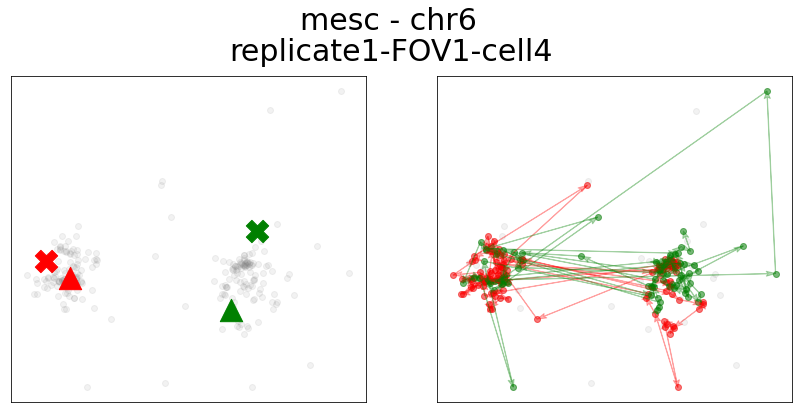

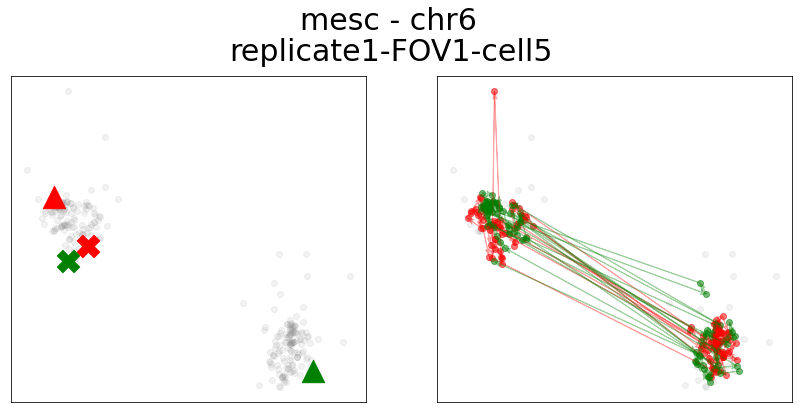

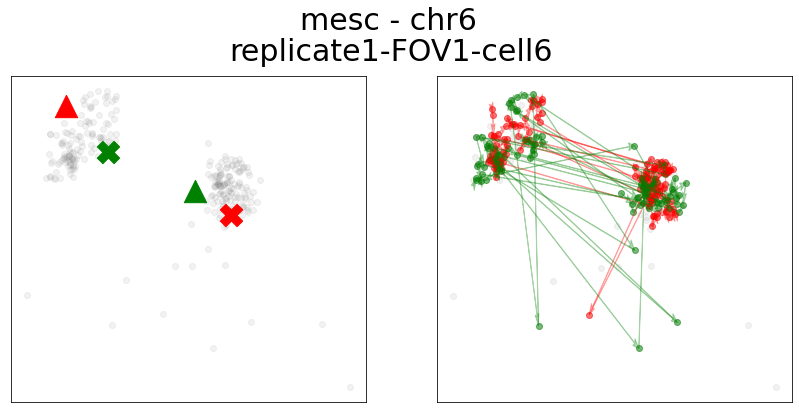

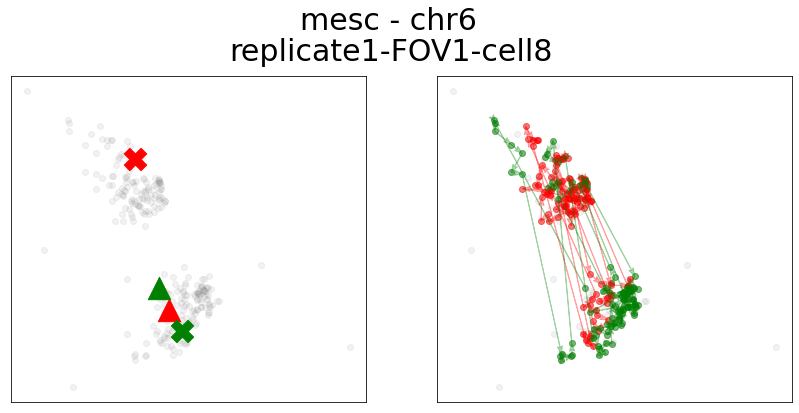

In [14]:
show_nucleus(res_all[0], background=True, title=None)
show_nucleus(res_all[1], background=True, title=None)
show_nucleus(res_all[2], background=True, title=None)
show_nucleus(res_all[3], background=True, title=None)

ここでは、k-meansの重心を元に、2つのアレルを再分離する。

In [15]:
from scipy.spatial import distance

res_all_allele = pd.DataFrame()

# res_all_allele2 = []

i = 0

for n_cell in range(len(res_all)):
    if len(res_all[n_cell]) > 1:
        for n_allele in range(len(res_all[n_cell])):
            a = res_all[n_cell][n_allele]
            a['Allele_ID'] = n_allele
            a['new_finalcellID'] = i
            i = i + 1
            res_all_allele = pd.concat([res_all_allele, a])
            #res_all_allele2.append([a])
    else :
        a = res_all[n_cell][0]
        a['Allele_ID'] = 0
        a['new_finalcellID'] = i
        i = i + 1
        #a = a.reset_index()                        
        res_all_allele = pd.concat([res_all_allele, a])
        #res_all_allele2.append([a])
        
res_all_allele['old_finalcellID'] = res_all_allele['finalcellID']
res_all_allele['finalcellID'] = res_all_allele['new_finalcellID']
res_all_allele

,replicate,FOV,cell,finalcellID,celltype,chr,hyb,geneID,x_hat,y_hat,z_hat,sig_x,sig_y,sig_z,Allele_ID,new_finalcellID,old_finalcellID
1,replicate1,1,4,0,mesc,chr6,0,Nanog_assoc#1,561.091077,207.518547,30.165820,1,1,1,0,0,0
2,replicate1,1,4,0,mesc,chr6,1,Non_Nanog_assoc#1,563.935066,210.304803,31.763496,1,1,1,0,0,0
5,replicate1,1,4,0,mesc,chr6,2,Nanog_assoc#2,561.893464,211.734352,33.976196,1,1,1,0,0,0
6,replicate1,1,4,0,mesc,chr6,3,Nanog_assoc#3,562.970370,215.593099,31.927050,1,1,1,0,0,0
7,replicate1,1,4,0,mesc,chr6,4,Foxp1,608.253058,202.147093,50.568457,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,replicate1,30,28,970,mesc,chr6,115,Ergic2,600.009301,545.064423,42.493858,1,1,1,0,970,672
151,replicate1,30,28,970,mesc,chr6,116,Rps4l,598.338215,544.600440,46.153844,1,1,1,0,970,672
152,replicate1,30,28,970,mesc,chr6,117,Caprin2,608.666086,547.494846,40.411927,1,1,1,0,970,672
154,replicate1,30,28,970,mesc,chr6,118,Nanog_assoc#20,609.622278,547.211054,40.800168,1,1,1,0,970,672


以下では、各アレルを1つの細胞のデータとして分離している。

In [16]:
res_all_allele_2 = pd.DataFrame()
res_all_allele2 = []

for n_cell in list(set(res_all_allele['old_finalcellID'].values)):
    _df = res_all_allele.loc[res_all_allele["old_finalcellID"]==n_cell,].copy()
    if len(_df) > 100:
        # Pandas のデータフレームから Numpy の行列 (Array) に変換
        cust_array = np.array([_df['x_hat'].tolist(),
                               _df['y_hat'].tolist(),
                               _df['z_hat'].tolist()
                               ], np.int32)

        # 行列を転置
        cust_array_t = cust_array.T


        # クラスタ分析を実行 (クラスタ数=2)
        cls = KMeans(n_clusters=2)
        pred = cls.fit_predict(cust_array_t)

        # クラスタのセントロイド (重心) を描く
        centers = cls.cluster_centers_

    #     # ここで、重心ではなく、座標の中央値を採用する。
    #     centers = np.array(_df['x_hat'].median(),
    #                       _df['y_hat'].median(),
    #                       _df['z_hat'].median())

        _df = _df.reset_index()
        _df['Allele_ID'] = 0
        for i in range(len(_df)):
            b = np.array([_df['x_hat'][i],
                          _df['y_hat'][i],
                          _df['z_hat'][i]
                               ], np.int32)
            a = distance.euclidean(b, centers[0]) - distance.euclidean(b, centers[1])
            if a > 0:
                _df.loc[i,'Allele_ID'] = 1
    else :
        _df['Allele_ID'] = 0
    
    res_all_allele_2 = pd.concat([res_all_allele_2, _df])
    
    for i in range(2):
        res_all_allele2.append([_df.loc[_df['Allele_ID']==i,].copy()])

In [17]:
len(res_all_allele2)

1222

In [18]:
import numpy as np
from scipy.spatial import distance

dist_list = []
dist_list_mean = []
dist_list_sd = []
dist_list_med = []
dist_list_max = []

df_res_concat = pd.DataFrame()

for n_res in range(len(res_all_allele2)):
    temp = res_all_allele2[n_res][0]
#     temp = temp.drop('level_0',axis=1)
    temp = temp.reset_index()
    dist_1 = []


    for i in range(1,len(temp)):
        dist_1.append(distance.euclidean(temp.loc[i-1,['x_hat','y_hat','z_hat']].values, 
                       temp.loc[i,['x_hat','y_hat','z_hat']].values) )

    dist_list.append(dist_1)
    dist_list_mean.append(np.mean(dist_1))
    dist_list_sd.append(np.std(dist_1))
    dist_list_med.append(np.median(dist_1))
#     dist_list_max.append(np.max(dist_1))
    
    #temp['Allele_ID'] = n_res
    df_res_concat = pd.concat([df_res_concat, temp])
    

/Users/HiroshiOchiai/opt/anaconda3/envs/jie/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/HiroshiOchiai/opt/anaconda3/envs/jie/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/HiroshiOchiai/opt/anaconda3/envs/jie/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/HiroshiOchiai/opt/anaconda3/envs/jie/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/HiroshiOchiai/opt/anaconda3/envs/jie/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.

[10, 18, 20, 24, 49, 65]

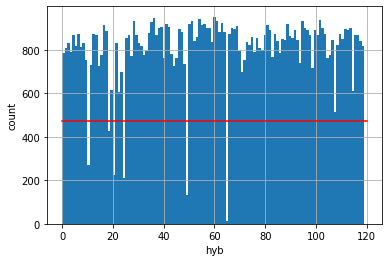

In [19]:
df_res_concat_count = df_res_concat.loc[:,['hyb', 'geneID']].groupby('hyb').count()
df_res_concat_count
df_res_concat['hyb'].hist(bins=120)
plt.xlabel("hyb")
plt.ylabel("count")
plt.plot([0, 120], 
         [int(df_res_concat_count.median().values[0])/1.8, int(df_res_concat_count.median().values[0])/1.8],color="red")

df_res_concat_count.median()
df_res_concat_count.median().values[0]
low_quality_hyb = df_res_concat_count[df_res_concat_count['geneID'] < int(df_res_concat_count.median().values[0])/1.8].index.values.tolist()
low_quality_hyb

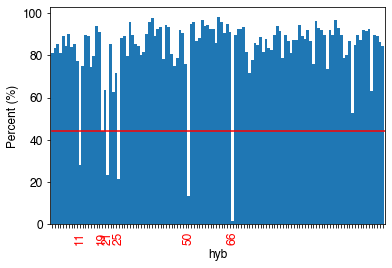

In [20]:

# フォントサイズを設定
plt.rcParams['font.size'] = 12

# フォントファミリーを設定
plt.rcParams['font.family'] = 'Helvetica'

df_res_concat_count = df_res_concat.loc[:,['hyb', 'geneID']].groupby('hyb').count()
# 'new_finalcellID' のユニークな値の数を計算
allele_unique = df_res_concat['new_finalcellID'].nunique()

# df_res_concat_countをallele_uniqueで割り、100を掛けてパーセンテージに変換
df_res_concat_count = (df_res_concat_count / allele_unique) * 100

# インデックスを列に戻す
df_res_concat_count.reset_index(inplace=True)

# 'hyb'列に1を加える
df_res_concat_count['hyb'] += 1

# 'hyb'を再度インデックスに設定
df_res_concat_count.set_index('hyb', inplace=True)

threshold = int(df_res_concat_count.median().values[0])/2

# threshold 以下の hyb を特定
below_threshold = df_res_concat_count[df_res_concat_count['geneID'] <= threshold].index

# バーグラフをプロット
ax = df_res_concat_count.plot(kind='bar', y='geneID', legend=False, width=1)

# x軸のラベルを操作
for i, t in enumerate(ax.get_xticklabels()):
    if int(t.get_text()) in below_threshold:
        t.set_color('red')  # ラベルを赤にする
    else:
        t.set_visible(False)  # ラベルを非表示にする

plt.xlabel("hyb")
plt.ylabel("Percent (%)")
plt.plot([0, 120], [threshold, threshold], color="red")
plt.grid(False)


ここで、各染色体内の輝点座標の中央値からの距離を計算する。その分布によって、排除する輝点を決める。

In [21]:
res_all_allele3 = []
for i in range(len(res_all_allele2)):
    _df = res_all_allele2[i][0].copy()
    _df['new_finalcellID'] = i
    _df['finalcellID'] = i
    _df = _df.reset_index()
    dist_1 = []
    
    for j in range(len(_df)):
        dist_1.append(distance.euclidean([_df['x_hat'].median(),
                                        _df['y_hat'].median(),
                                        _df['z_hat'].median()], 
                                       _df.loc[j,['x_hat','y_hat','z_hat']].values) )
        
    _df['dist_med'] = dist_1
    _df['allele_med_x'] = _df['x_hat'].median()
    _df['allele_med_y'] = _df['y_hat'].median()
    _df['allele_med_z'] = _df['z_hat'].median()
    
    
    res_all_allele3.append([_df])

34.95613084002333


(array([157., 154., 159., 185., 135., 116., 117.,  86.,  97.,  85.,  96.,
        106., 101.,  99.,  87.,  86.,  81.,  85.,  83.,  64.,  74.,  69.,
         50.,  50.,  48.,  56.,  46.,  53.,  57.,  43.,  69.,  53.,  47.,
         38.,  33.,  33.,  34.,  26.,  37.,  57.,  34.,  26.,  41.,  55.,
         40.,  38.,  32.,  30.,  27.,  29.,  30.,  27.,  18.,  18.,  15.,
         17.,   8.,   8.,   7.,   8.,   9.,   4.,   7.,   6.,   5.,   7.,
          9.,   3.,   4.,   2.,   5.,   5.,   3.,   4.,  12.,   2.,  12.,
          5.,  10.,  12.,   3.,   2.,   1.,   3.,   1.,   2.,   0.,   0.,
          3.,   4.,   2.,   4.,   5.,   0.,   4.,   9.,  13.,   5.,   2.,
          3.]),
 array([ 34.9701607 ,  36.02945089,  37.08874108,  38.14803127,
         39.20732146,  40.26661165,  41.32590183,  42.38519202,
         43.44448221,  44.5037724 ,  45.56306259,  46.62235278,
         47.68164297,  48.74093316,  49.80022335,  50.85951354,
         51.91880373,  52.97809392,  54.03738411,  55.0966743 

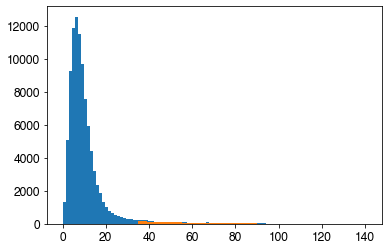

In [22]:
a = pd.DataFrame()
for i in range(len(res_all_allele3)):
    a = pd.concat([a, res_all_allele3[i][0]])

_threshold = a['dist_med'].mean() + 2 * a['dist_med'].std()
print(_threshold)
plt.hist(a['dist_med'], bins=100, label='all')
plt.hist(a.loc[a['dist_med'] > _threshold,'dist_med'], bins=100, label='thresholded')


#### ここで、輝点median 座標からの距離が閾値(34.9565)以上のものを排除する。さらに、countの少ないhybも除去する。

In [23]:
# res_all_red = list(itemgetter(*np.where((np.array(dist_list_med) > 2) & (np.array(dist_list_med) < 10))[0].tolist())(res_all_allele2)
# )

_df = []
for i in range(len(res_all_allele3)):
    _df1 = res_all_allele3[i][0].copy()
    _df1 = _df1.loc[_df1['dist_med']<_threshold,:].copy()
    for b in low_quality_hyb:
        _df1 = _df1.loc[_df1['hyb'] != b, :].copy()
    _df.append([_df1])

res_all_red = _df

In [24]:
np.unique(low_quality_hyb)

array([10, 18, 20, 24, 49, 65])

In [25]:
res_all_red[0][0]

,level_0,index,replicate,FOV,cell,finalcellID,celltype,chr,hyb,geneID,...,sig_x,sig_y,sig_z,Allele_ID,new_finalcellID,old_finalcellID,dist_med,allele_med_x,allele_med_y,allele_med_z
0,0,1,replicate1,1,4,0,mesc,chr6,0,Nanog_assoc#1,...,1,1,1,0,0,0,8.660323,560.470016,207.755603,38.800592
1,1,2,replicate1,1,4,0,mesc,chr6,1,Non_Nanog_assoc#1,...,1,1,1,0,0,0,8.247770,560.470016,207.755603,38.800592
2,2,5,replicate1,1,4,0,mesc,chr6,2,Nanog_assoc#2,...,1,1,1,0,0,0,6.413380,560.470016,207.755603,38.800592
3,3,6,replicate1,1,4,0,mesc,chr6,3,Nanog_assoc#3,...,1,1,1,0,0,0,10.720247,560.470016,207.755603,38.800592
4,19,36,replicate1,1,4,0,mesc,chr6,23,Mtmr14,...,1,1,1,0,0,0,5.184336,560.470016,207.755603,38.800592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,158,127,replicate1,1,4,0,mesc,chr6,67,Novo_2018#3,...,1,1,1,0,0,0,2.315069,560.470016,207.755603,38.800592
96,159,129,replicate1,1,4,0,mesc,chr6,68,25k_nega#17,...,1,1,1,0,0,0,3.982879,560.470016,207.755603,38.800592
97,160,131,replicate1,1,4,0,mesc,chr6,69,25k_nega#18,...,1,1,1,0,0,0,3.544707,560.470016,207.755603,38.800592
98,161,133,replicate1,1,4,0,mesc,chr6,70,25k_nega#19,...,1,1,1,0,0,0,7.089483,560.470016,207.755603,38.800592


/Users/HiroshiOchiai/opt/anaconda3/envs/jie/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


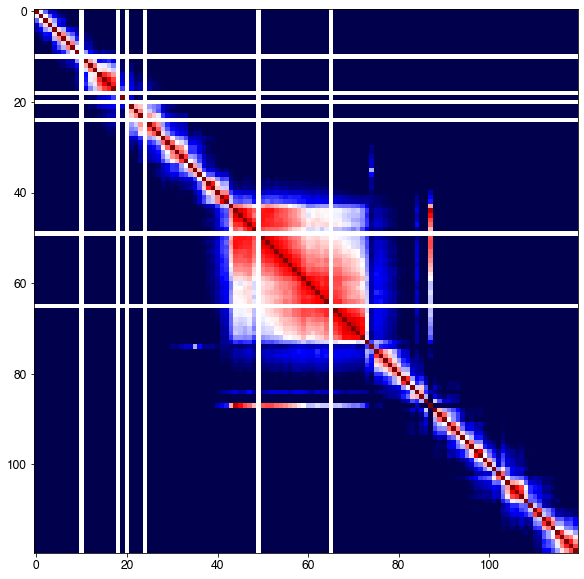

In [26]:
# flatten
res_all_flat = [fiber for cell_res in res_all_red for fiber in cell_res]
med_dist_mat_all = plot.calc_med_dist_mat(res_all_flat, len(gene_dist))

# plot
fig, axs = plt.subplots(figsize = (10, 10))
axs.imshow(med_dist_mat_all*100, cmap = 'seismic_r', vmax = 1000)


ここで、low qualityのもの、[10, 18, 19, 20, 22, 24, 49, 65, 87]を排除する。

In [27]:
_df = pd.DataFrame()

for i in range(len(res_all_red)):
    _df = pd.concat([_df,res_all_red[i][0]])

_df['old_hyb'] = _df['hyb'].values.tolist()

to_be_excuded = low_quality_hyb

to_be_excuded += [74, 84, 87]

for i in to_be_excuded:
    _df = _df[_df['hyb']!=i].copy()

from scipy.stats import rankdata

b = _df['hyb'].unique().tolist()
b.sort()
c = rankdata(b).tolist()
for i in range(len(c)):
    c[i] = int(c[i]) -1


for i in range(len(b)):
    _df.loc[_df['hyb']==b[i],'hyb'] = c[i]


_df0 = []
for i in _df['finalcellID'].unique().tolist():
    _df1 = _df.loc[_df['finalcellID']==i,:].copy()
    _df0.append([_df1])

res_all_red2 = _df0

/Users/HiroshiOchiai/opt/anaconda3/envs/jie/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


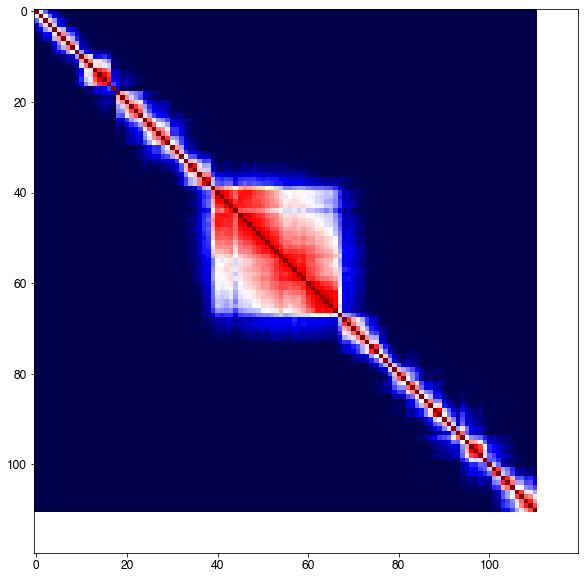

In [28]:
# flatten
res_all_flat = [fiber for cell_res in res_all_red2 for fiber in cell_res]
med_dist_mat_all = plot.calc_med_dist_mat(res_all_flat, len(gene_dist))

# plot
fig, axs = plt.subplots(figsize = (10, 10))
axs.imshow(med_dist_mat_all*100, cmap = 'seismic_r', vmax = 1000)

また、gene_distも変更する。

In [29]:
df_refgen

,Region ID,Name,Channel,Chrom,Start,End,Chrom ID,hyb,delta
52,1,Nanog_assoc#1,3,chr6,94672506,94707506,6,0,0
73,2,Non_Nanog_assoc#1,2,chr6,95937507,95962506,6,1,1265001
53,3,Nanog_assoc#2,3,chr6,97192506,97217506,6,2,2520000
54,4,Nanog_assoc#3,1,chr6,97932506,97967506,6,3,3260000
41,5,Foxp1,2,chr6,99031960,99056959,6,4,4359454
...,...,...,...,...,...,...,...,...,...
37,116,Ergic2,2,chr6,148184029,148209028,6,115,53511523
105,117,Rps4l,1,chr6,148342157,148367156,6,116,53669651
28,118,Caprin2,2,chr6,148878328,148903327,6,117,54205822
71,119,Nanog_assoc#20,3,chr6,148973978,148998978,6,118,54301472


In [30]:
df_refgen2 = df_refgen.copy()

to_be_excuded = low_quality_hyb
for i in to_be_excuded:
    df_refgen2 = df_refgen2[df_refgen2['hyb']!=i].copy()

from scipy.stats import rankdata


for i in range(len(b)):
    df_refgen2.loc[df_refgen2['hyb']==b[i],'hyb'] = c[i]

df_refgen2['delta'] = df_refgen2['Start'] - df_refgen2['Start'].iloc[0]
    
# grab reference genome
gene_dist2 = df_refgen2[df_refgen2['Chrom'] == chosen_chrom]['delta']

In [31]:
low_quality_hyb
# to_be_excuded = low_quality_hyb
# # to_be_excuded[len(to_be_excuded):len(to_be_excuded)] = [74, 84, 87]
# to_be_excuded

[10, 18, 20, 24, 49, 65, 74, 84, 87]

In [32]:
df_refgen2

,Region ID,Name,Channel,Chrom,Start,End,Chrom ID,hyb,delta
52,1,Nanog_assoc#1,3,chr6,94672506,94707506,6,0,0
73,2,Non_Nanog_assoc#1,2,chr6,95937507,95962506,6,1,1265001
53,3,Nanog_assoc#2,3,chr6,97192506,97217506,6,2,2520000
54,4,Nanog_assoc#3,1,chr6,97932506,97967506,6,3,3260000
41,5,Foxp1,2,chr6,99031960,99056959,6,4,4359454
...,...,...,...,...,...,...,...,...,...
37,116,Ergic2,2,chr6,148184029,148209028,6,106,53511523
105,117,Rps4l,1,chr6,148342157,148367156,6,107,53669651
28,118,Caprin2,2,chr6,148878328,148903327,6,108,54205822
71,119,Nanog_assoc#20,3,chr6,148973978,148998978,6,109,54301472


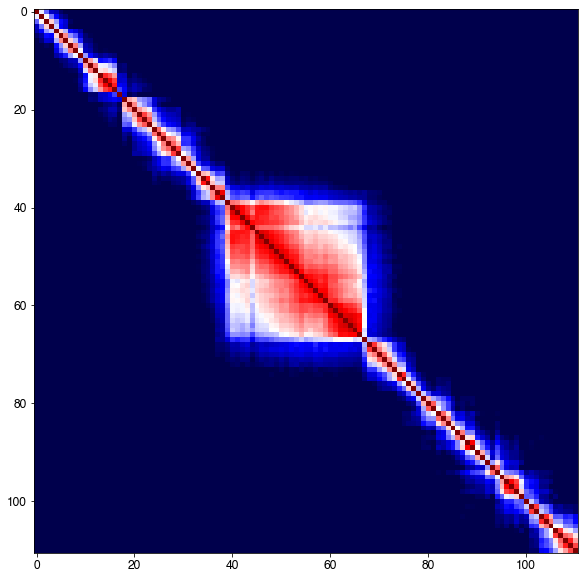

In [33]:
# flatten
res_all_flat = [fiber for cell_res in res_all_red2 for fiber in cell_res]
med_dist_mat_all = plot.calc_med_dist_mat(res_all_flat, len(gene_dist2))

# plot
fig, axs = plt.subplots(figsize = (10, 10))
axs.imshow(med_dist_mat_all*100, cmap = 'seismic_r', vmax = 1000)

/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_45693/1914048281.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic_r").copy()
  cmap.set_bad("gray")


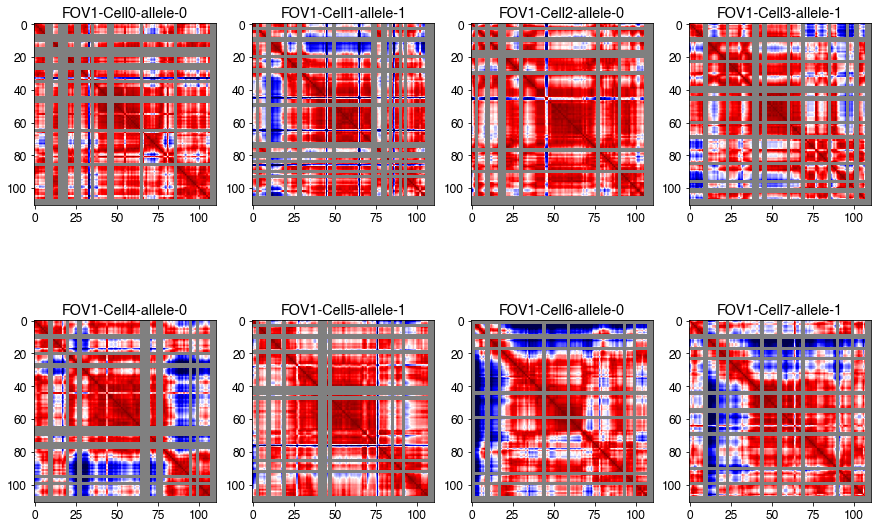

In [34]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


cmap = plt.get_cmap("seismic_r")
cmap.set_bad("gray")

fig, axs = plt.subplots(2, 4, figsize = (15, 10))
# example_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8]

example_idxs = list(range(len(res_all_red2)))

for idx, ax in zip(example_idxs, axs.flatten()):
    
    # median distance matrix for single fiber
    mat = plot.calc_med_dist_mat([res_all_flat[idx]], len(gene_dist2))
    
    # grab metadata
    fov, cellid, allele = res_all_flat[idx].iloc[0]['FOV'], res_all_flat[idx].iloc[0]['finalcellID'], res_all_flat[idx].iloc[0]['Allele_ID']
    
    # show
    ax.imshow(mat*100, cmap = cmap, vmax = 3000)
#     ax.set_title("{0}-FOV{1}-Cell{2} : {3}".format(rep, fov, cellid, chosen_chrom))
    ax.set_title("FOV{0}-Cell{1}-allele-{2}".format(fov, cellid, allele))

以下ではアレルごとに分ける。

In [35]:
_df = pd.DataFrame()

for i in range(len(res_all_red2)):
    _df = pd.concat([_df, res_all_red2[i][0]])

res_all_red_allele_each =[]

for i in list(set(_df['old_finalcellID'].values)):
    _df1 = _df.loc[_df['old_finalcellID']==i,:]
    a = []
    for j in list(set(_df1['Allele_ID'].values)):
        a.append(_df1.loc[_df1['Allele_ID']==j,:])
    res_all_red_allele_each.append(a)

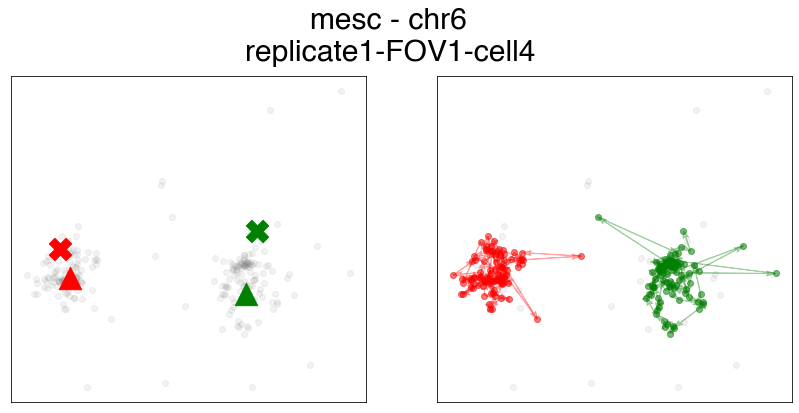

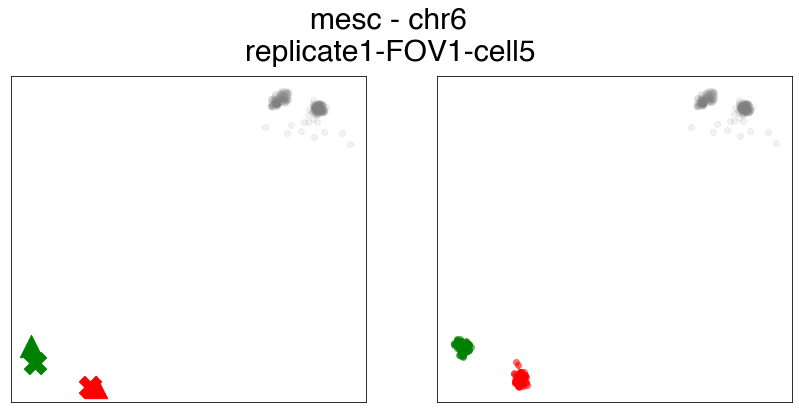

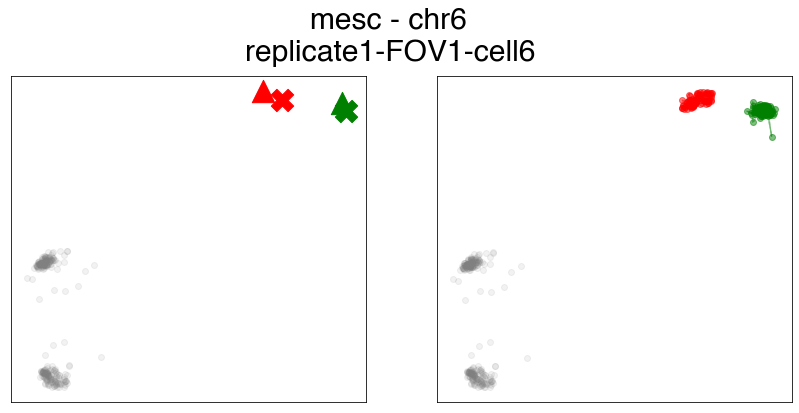

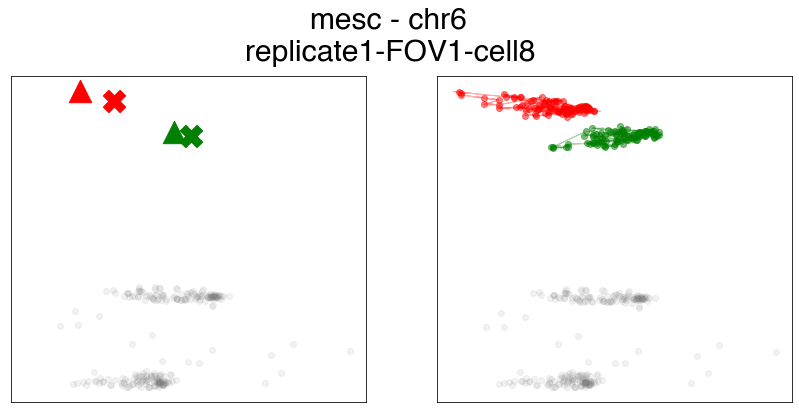

In [36]:
show_nucleus(res_all_red_allele_each[0], background=True, title=None)
show_nucleus(res_all_red_allele_each[1], background=True, title=None)
show_nucleus(res_all_red_allele_each[2], background=True, title=None)
show_nucleus(res_all_red_allele_each[3], background=True, title=None)

In [37]:
all_chr_df = pd.DataFrame()

for i in range(len(res_all_red2)):
    a = res_all_red2[i]
    for j in range(len(a)):
        all_chr_df = pd.concat([all_chr_df, a[j]])

In [38]:
os.makedirs(os.path.join(dir, "2_analyzed_data"), exist_ok=True)
all_chr_df.to_csv(os.path.join(dir, "2_analyzed_data", "seq_DNA-FISH_after_correction_rep1.csv"),
                        index = False)

In [39]:
all_chr_df

,level_0,index,replicate,FOV,cell,finalcellID,celltype,chr,hyb,geneID,...,sig_y,sig_z,Allele_ID,new_finalcellID,old_finalcellID,dist_med,allele_med_x,allele_med_y,allele_med_z,old_hyb
0,0.0,1,replicate1,1,4,0,mesc,chr6,0,Nanog_assoc#1,...,1,1,0,0,0,8.660323,560.470016,207.755603,38.800592,0
1,1.0,2,replicate1,1,4,0,mesc,chr6,1,Non_Nanog_assoc#1,...,1,1,0,0,0,8.247770,560.470016,207.755603,38.800592,1
2,2.0,5,replicate1,1,4,0,mesc,chr6,2,Nanog_assoc#2,...,1,1,0,0,0,6.413380,560.470016,207.755603,38.800592,2
3,3.0,6,replicate1,1,4,0,mesc,chr6,3,Nanog_assoc#3,...,1,1,0,0,0,10.720247,560.470016,207.755603,38.800592,3
4,19.0,36,replicate1,1,4,0,mesc,chr6,20,Mtmr14,...,1,1,0,0,0,5.184336,560.470016,207.755603,38.800592,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,NaN,149,replicate1,30,28,1220,mesc,chr6,106,Ergic2,...,1,1,0,1220,672,16.150686,613.349522,553.956422,44.447189,115
78,NaN,151,replicate1,30,28,1220,mesc,chr6,107,Rps4l,...,1,1,0,1220,672,17.770380,613.349522,553.956422,44.447189,116
79,NaN,152,replicate1,30,28,1220,mesc,chr6,108,Caprin2,...,1,1,0,1220,672,8.942587,613.349522,553.956422,44.447189,117
80,NaN,154,replicate1,30,28,1220,mesc,chr6,109,Nanog_assoc#20,...,1,1,0,1220,672,8.526024,613.349522,553.956422,44.447189,118


## seq-RNA-FISHデータ

以下から、DNA-seqFISHとの関係性を見ている。

以下ではDNA-seqFISHの座標に該当する位置で転写が起こっていたかどうかを判定していく。
DNA-seqFISH locusと最近傍の転写輝点との距離を計算したが、結局DNA-seqFISH側の輝点が無いとかいろんな問題が出てくる。そのため、DNA-seqFISH輝点の中央値座標からの距離がDNA-seqFISHで決めた閾値、34.956以上離れていれば転写はなかった、とする。この方法だと、染色体領域が近かった場合に一つしか転写輝点が無いけと両対立遺伝子で転写してると判定される。一方で、実際に片対立遺伝子からしか転写していなくても、判定は用意ではないので、このまま進める。

In [ ]:
import pandas as pd
import glob
import re
import os
import numpy as np

import scipy.spatial as ss  
import shutil
import zipfile


# 現在のディレクトリのパスを取得
current_directory = os.getcwd()
# 現在のディレクトリの2つ上の階層のパスを取得
dir = os.path.dirname(current_directory)

# 移動させるzipファイルの名前
zip_file = 'RNA_seqFISH_spot_detection.zip'

# zipファイルの完全なパス
full_zip_path = os.path.join(dir, "X1_accessory_data",zip_file)

# zipファイルを解凍
with zipfile.ZipFile(full_zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(dir, "X1_accessory_data"))

# 元のzipファイルおよび解凍に伴い出現する不要なファイルを削除
os.remove(full_zip_path)

DNA_seqFISH_coords = pd.read_csv(os.path.join(dir, "2_analyzed_data", "seq_DNA-FISH_after_correction_rep1.csv"))
# DNA_seqFISH_coords = DNA_seqFISH_coords.drop(columns='level_0')
# DNA_seqFISH_coords = DNA_seqFISH_coords.reset_index()
ref_data = pd.read_csv(os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-summary.csv"))

RNA_target_list = ref_data.loc[(ref_data['exp_type']=='RNA_seqFISH') & (~ref_data['Locus_ID'].isna()),'target_ID'].tolist()
input_path = os.path.join(dir, "X1_accessory_data", "RNA_seqFISH_spot_detection")

DNA_seqFISH_coords_w_dist = pd.DataFrame()

for RNA_id in RNA_target_list:
    print(RNA_id)
    Locus_id = ref_data.loc[ref_data['target_ID']==RNA_id,'Locus_ID'].tolist()
    geneID = ref_data.loc[(ref_data['exp_type']=='DNA_seqFISH') & (ref_data['Locus_ID']==Locus_id[0]),'geneID'].values[0]
    
    for Pos in range(1,31):        
        path = os.path.join(input_path, 'Pos'+str(Pos).zfill(2), '*'+RNA_id+'clusters.csv')
        l = glob.glob(path)

        cluster_data = np.loadtxt(l[0], delimiter=';')
       
        if (len(cluster_data)>0) & (sum((DNA_seqFISH_coords['FOV']==Pos) & (DNA_seqFISH_coords['geneID']==geneID))>0):
            _df = DNA_seqFISH_coords.loc[(DNA_seqFISH_coords['FOV']==Pos) & (DNA_seqFISH_coords['geneID']==geneID),].copy()
            _df = _df.drop(columns='level_0')
            _df['R_D_dist'] = ''
            _df['R_cluster_index'] = ''
            _df = _df.reset_index(drop=True)
            dna_coords = _df.loc[:,['allele_med_z','allele_med_y', 'allele_med_x']].values

            # 最近傍の輝点を見つける。https://inarizuuuushi.hatenablog.com/entry/2019/02/21/100000
            # kd tree の作成 (leafsizeは展開をしない節内点数上限)

            if len(cluster_data.shape) == 1:
                b = cluster_data + 5000
                cluster_data = np.vstack((cluster_data, b))
            tree = ss.KDTree(cluster_data[:,[0,1,2]])
#             tree = ss.KDTree(cluster_data[:,[0,1,2]])

            for j in range(len(_df)):
                d, i = tree.query(dna_coords[:,[0,1,2]][j])
                _df.loc[j,'R_D_dist'] = d
                _df.loc[j,'R_cluster_index'] = i

            DNA_seqFISH_coords_w_dist = pd.concat([DNA_seqFISH_coords_w_dist,_df])

In [19]:
DNA_seqFISH_coords

,level_0,index,replicate,FOV,cell,finalcellID,celltype,chr,hyb,geneID,...,sig_y,sig_z,Allele_ID,new_finalcellID,old_finalcellID,dist_med,allele_med_x,allele_med_y,allele_med_z,old_hyb
0,0.0,1,replicate1,1,4,0,mesc,chr6,0,Nanog_assoc#1,...,1,1,0,0,0,8.660323,560.470016,207.755603,38.800592,0
1,1.0,2,replicate1,1,4,0,mesc,chr6,1,Non_Nanog_assoc#1,...,1,1,0,0,0,8.247770,560.470016,207.755603,38.800592,1
2,2.0,5,replicate1,1,4,0,mesc,chr6,2,Nanog_assoc#2,...,1,1,0,0,0,6.413380,560.470016,207.755603,38.800592,2
3,3.0,6,replicate1,1,4,0,mesc,chr6,3,Nanog_assoc#3,...,1,1,0,0,0,10.720247,560.470016,207.755603,38.800592,3
4,19.0,36,replicate1,1,4,0,mesc,chr6,20,Mtmr14,...,1,1,0,0,0,5.184336,560.470016,207.755603,38.800592,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89592,NaN,149,replicate1,30,28,1220,mesc,chr6,106,Ergic2,...,1,1,0,1220,672,16.150686,613.349522,553.956422,44.447189,115
89593,NaN,151,replicate1,30,28,1220,mesc,chr6,107,Rps4l,...,1,1,0,1220,672,17.770380,613.349522,553.956422,44.447189,116
89594,NaN,152,replicate1,30,28,1220,mesc,chr6,108,Caprin2,...,1,1,0,1220,672,8.942587,613.349522,553.956422,44.447189,117
89595,NaN,154,replicate1,30,28,1220,mesc,chr6,109,Nanog_assoc#20,...,1,1,0,1220,672,8.526024,613.349522,553.956422,44.447189,118


(array([4.460e+02, 1.024e+03, 9.110e+02, 8.270e+02, 8.830e+02, 1.070e+03,
       1.109e+03, 1.249e+03, 1.225e+03, 1.269e+03, 1.238e+03, 1.236e+03,
       1.220e+03, 1.126e+03, 1.134e+03, 1.091e+03, 1.097e+03, 9.820e+02,
       9.770e+02, 9.110e+02, 8.990e+02, 9.110e+02, 8.080e+02, 7.890e+02,
       7.560e+02, 7.440e+02, 7.420e+02, 7.360e+02, 6.430e+02, 6.060e+02,
       6.060e+02, 5.710e+02, 5.480e+02, 5.200e+02, 5.430e+02, 5.720e+02,
       5.220e+02, 5.470e+02, 5.510e+02, 4.790e+02, 4.570e+02, 4.060e+02,
       4.220e+02, 4.220e+02, 4.340e+02, 4.030e+02, 3.980e+02, 4.340e+02,
       3.910e+02, 3.880e+02, 3.880e+02, 3.750e+02, 3.210e+02, 3.480e+02,
       3.350e+02, 2.880e+02, 2.970e+02, 2.870e+02, 3.080e+02, 3.090e+02,
       3.030e+02, 3.000e+02, 2.550e+02, 2.650e+02, 2.680e+02, 2.170e+02,
       2.920e+02, 2.650e+02, 2.470e+02, 2.200e+02, 2.120e+02, 2.030e+02,
       2.330e+02, 2.140e+02, 2.040e+02, 1.970e+02, 1.850e+02, 2.370e+02,
       1.950e+02, 1.900e+02, 2.290e+02, 1.890e+02,

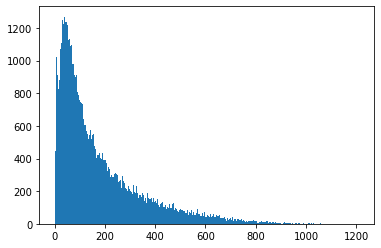

In [20]:
import numpy as np
import matplotlib.pyplot as plt
 
# ヒストグラムを出力
print(plt.hist(DNA_seqFISH_coords_w_dist['R_D_dist'], bins=300))
# print(plt.hist(np.log10(DNA_seqFISH_coords_w_dist['R_D_dist']), bins=80))

(array([ 2.,  0.,  1.,  5.,  3.,  4., 14.,  8., 10., 21., 12., 18., 21.,
       16., 17., 34., 25., 20., 20., 33., 31., 31., 22., 56., 39., 30.,
       42., 39., 48., 42., 39., 32., 42., 39., 44., 35., 53., 41., 50.,
       51., 62., 47., 40., 39., 33., 35., 56., 37., 43., 48., 33., 51.,
       42., 39., 37., 27., 45., 38., 45., 36., 37., 30., 26., 49., 37.,
       49., 40., 30., 30., 34., 28., 32., 32., 32., 39., 37., 33., 30.,
       42., 37., 39., 36., 36., 24., 28., 43., 32., 32., 28., 34., 33.,
       41., 33., 22., 31., 28., 41., 36., 34., 23., 28., 29., 33., 31.,
       42., 37., 38., 45., 35., 43., 46., 31., 35., 28., 47., 43., 44.,
       37., 32., 36., 35., 35., 50., 39., 51., 42., 42., 51., 34., 54.,
       44., 58., 47., 40., 41., 48., 39., 36., 34., 42., 42., 39., 43.,
       42., 42., 47., 52., 37., 53., 48., 53., 37., 49., 43., 47., 35.,
       45., 38., 48., 44., 34., 55., 44., 46., 37., 42., 40., 59., 55.,
       46., 64., 64., 44., 53., 49., 37., 55., 50., 49., 54., 4

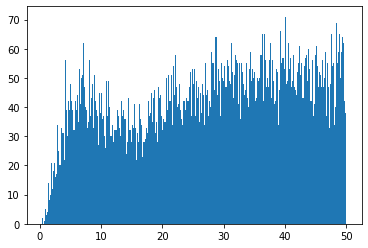

In [21]:
# print(plt.hist(DNA_seqFISH_coords_w_dist['R_D_dist'], bins=300, label = 'all'))
print(plt.hist(DNA_seqFISH_coords_w_dist.loc[DNA_seqFISH_coords_w_dist['R_D_dist']<50,'R_D_dist'].values, bins=300, label = 'thresholded'))

15くらいに明確な谷が認められる。しかし、これはあくまでも対象領域DNA-seqFISHの座標の中央値からの距離なので、予定通り34.956ピクセルを閾値に設定する。

DNA-seqFISHで認識されていない輝点があるため、DNA-seqFISH輝点に転写状態をアサインするのは良くない。
別のファイルに情報を入れる。

In [22]:
import pandas as pd
import glob
import re
import os
import numpy as np

import scipy.spatial as ss  


DNA_seqFISH_coords = pd.read_csv(os.path.join(dir, "2_analyzed_data", "seq_DNA-FISH_after_correction_rep1.csv"))
DNA_seqFISH_coords = DNA_seqFISH_coords.drop(columns='level_0')
DNA_seqFISH_coords = DNA_seqFISH_coords.reset_index(drop=True).copy()
ref_data = pd.read_csv(os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-summary.csv"))

RNA_target_list = ref_data.loc[(ref_data['exp_type']=='RNA_seqFISH') & (~ref_data['Locus_ID'].isna()),'target_ID'].tolist()
input_path = os.path.join(dir, "X1_accessory_data", "RNA_seqFISH_spot_detection")

DNA_seqFISH_coords['R_D_dist'] = float('nan')
DNA_seqFISH_coords['R_cluster_num'] = float('nan')

Transcription_state_summary = pd.DataFrame()

for RNA_id in RNA_target_list:
    print(RNA_id)
    Locus_id = ref_data.loc[ref_data['target_ID']==RNA_id,'Locus_ID'].tolist()
    geneID = ref_data.loc[(ref_data['exp_type']=='DNA_seqFISH') & (ref_data['Locus_ID']==Locus_id[0]),'geneID'].values[0]
    
    for Pos in range(1,31):        
        path = os.path.join(input_path, 'Pos'+str(Pos).zfill(2), '*'+RNA_id+'clusters.csv')
        l = glob.glob(path)
        
        cluster_data = np.loadtxt(l[0], delimiter=';')
        
        if len(cluster_data.shape)==1:
            if len(cluster_data)==5:
                if cluster_data[5]>0:
                    cluster_data = cluster_data[np.ravel(cluster_data[:,[5]])>0]

                    column_names = ["z", "y", "x", "R_cluster_num", "R_cluster_index", "cell"]
                    cluster_data_df = pd.DataFrame(cluster_data, columns=column_names)
                    cluster_data_df['FOV'] = Pos
                    cluster_data_df['FOV'] = Pos
                    cluster_data_df['RNA_id'] = RNA_id
                    cluster_data_df['Locus_id'] = Locus_id[0]
                    cluster_data_df['geneID'] = geneID[0]
                    cluster_data_df = cluster_data_df.reset_index(drop=True)

                    if (len(cluster_data)>0) & (sum((DNA_seqFISH_coords['FOV']==Pos) & (DNA_seqFISH_coords['geneID']==geneID))>0):
                        _df = DNA_seqFISH_coords.loc[(DNA_seqFISH_coords['FOV']==Pos) & (DNA_seqFISH_coords['geneID']==geneID),].copy()
            #             _df = _df.drop(columns='level_0')
                        _df = _df.reset_index(drop=False)
                        dna_coords = _df.loc[:,['allele_med_z','allele_med_y', 'allele_med_x']].values

                        # 最近傍の輝点を見つける。https://inarizuuuushi.hatenablog.com/entry/2019/02/21/100000
                        # kd tree の作成 (leafsizeは展開をしない節内点数上限)


                        if len(dna_coords.shape) == 1:
                            b = dna_coords[:,[0,1,2]].to_numpy() + 5000
                            cluster_data = np.vstack((dna_coords[:,[0,1,2]].to_numpy(), b))
                        tree = ss.KDTree(dna_coords[:,[0,1,2]])
            #             tree = ss.KDTree(cluster_data[:,[0,1,2]])

                        for j in range(len(cluster_data_df)):
                            d, i = tree.query(cluster_data[:,[0,1,2]][j])

                            cluster_data_df.loc[j,'R_D_dist'] = d
                            cluster_data_df.loc[j,'Allele_ID'] = _df.loc[i,['Allele_ID']].values
                            cluster_data_df.loc[j,'finalcellID'] = _df.loc[i,['finalcellID']].values

                        Transcription_state_summary = pd.concat([Transcription_state_summary,cluster_data_df])
        
        else:
            if any(cluster_data[:,[5]])>0:
                cluster_data = cluster_data[np.ravel(cluster_data[:,[5]])>0]

                column_names = ["z", "y", "x", "R_cluster_num", "R_cluster_index", "cell"]
                cluster_data_df = pd.DataFrame(cluster_data, columns=column_names)
                cluster_data_df['FOV'] = Pos
                cluster_data_df['FOV'] = Pos
                cluster_data_df['RNA_id'] = RNA_id
                cluster_data_df['Locus_id'] = Locus_id[0]
                cluster_data_df['geneID'] = geneID
                cluster_data_df = cluster_data_df.reset_index(drop=True)

                if (len(cluster_data)>0) & (sum((DNA_seqFISH_coords['FOV']==Pos) & (DNA_seqFISH_coords['geneID']==geneID))>0):
                    _df = DNA_seqFISH_coords.loc[(DNA_seqFISH_coords['FOV']==Pos) & (DNA_seqFISH_coords['geneID']==geneID),].copy()
        #             _df = _df.drop(columns='level_0')
                    _df = _df.reset_index(drop=False)
                    dna_coords = _df.loc[:,['allele_med_z','allele_med_y', 'allele_med_x']].values

                    # 最近傍の輝点を見つける。https://inarizuuuushi.hatenablog.com/entry/2019/02/21/100000
                    # kd tree の作成 (leafsizeは展開をしない節内点数上限)


                    if len(dna_coords.shape) == 1:
                        b = dna_coords[:,[0,1,2]].to_numpy() + 5000
                        cluster_data = np.vstack((dna_coords[:,[0,1,2]].to_numpy(), b))
                    tree = ss.KDTree(dna_coords[:,[0,1,2]])
        #             tree = ss.KDTree(cluster_data[:,[0,1,2]])

                    for j in range(len(cluster_data_df)):
                        d, i = tree.query(cluster_data[:,[0,1,2]][j])

                        cluster_data_df.loc[j,'R_D_dist'] = d
                        cluster_data_df.loc[j,'Allele_ID'] = _df.loc[i,['Allele_ID']].values[0]
                        cluster_data_df.loc[j,'finalcellID'] = _df.loc[i,['finalcellID']].values[0]

                    Transcription_state_summary = pd.concat([Transcription_state_summary,cluster_data_df])
                    
Transcription_state_summary

Cmas
Wnk1
Brk1
Arl8b
Sec13
Setd5
Kras
Cops7a
Tamm41
Atg7
Wbp11
Caprin2
Bhlhe40
Mrps35
Gabarapl1
M6pr


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos13/ND16_C1_TyR_Gabarapl1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos17/ND16_C1_TyR_Gabarapl1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos18/ND16_C1_TyR_Gabarapl1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/

Mfap5
Necap1
Aicda
1700063H04Rik
Tada3
Fancd2os
Tmem40
Ncapd2
Gm10069
BC049715
Rep15
Fkbp4
Ybx3
Arpc4
Mbd4
Rps4l
Tsen2


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos05/ND06_C2_TyR_Rps4lclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos07/ND06_C2_TyR_Rps4lclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos11/ND06_C2_TyR_Rps4lclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49

Ldhb
Golt1b
Ndufa9
Bms1
Rad18


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos13/ND11_C2_TyR_Bms1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


Erc1
Fgfr1op2
Mtmr14


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos11/ND15_C2_TyR_Mtmr14clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


Sumf1


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos11/ND16_C2_TyR_Sumf1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos17/ND16_C2_TyR_Sumf1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos22/ND16_C2_TyR_Sumf1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49

Foxj2
Nanog


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos17/ND17_C2_TyR_Foxj2clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


Gdf3
Apobec1
Rimklb
Arl6ip5
Il17rc


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos17/ND23_C2_TyR_Il17rcclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos22/ND23_C2_TyR_Il17rcclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


Cand2


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos17/ND24_C2_TyR_Cand2clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos01/ND25_C2_TyR_Mrpl51clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos02/ND25_C2_TyR_Mrpl51clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_

Mrpl51
Rhno1


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos19/ND25_C2_TyR_Mrpl51clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos20/ND25_C2_TyR_Mrpl51clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos21/ND25_C2_TyR_Mrpl51clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel

1700101I11Rik
Plekha5


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos04/ND27_C2_TyR_1700101I11Rikclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos08/ND27_C2_TyR_1700101I11Rikclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos17/ND27_C2_TyR_1700101I11Rikclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6df

Tigar


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos11/ND02_C3_TyR_Tigarclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos29/ND02_C3_TyR_Tigarclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


Tspan9


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos17/ND03_C3_TyR_Tspan9clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


Foxp1
Chd4


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos29/ND05_C3_TyR_Chd4clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


Creld1
Tmcc1
Resf1


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos03/ND07_C3_TyR_Tmcc1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos06/ND07_C3_TyR_Tmcc1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos15/ND07_C3_TyR_Tmcc1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49

Clstn3
Cecr2
Stk38l


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos01/ND10_C3_TyR_Cecr2clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos02/ND10_C3_TyR_Cecr2clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos03/ND10_C3_TyR_Cecr2clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49

Lrp6
Adipor2
Ergic2
Zfp239


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos21/ND15_C3_TyR_Zfp239clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos24/ND15_C3_TyR_Zfp239clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos27/ND15_C3_TyR_Zfp239clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel

Eps8
Itpr1


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos27/ND16_C3_TyR_Eps8clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


Etv6
Slc2a3


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos09/ND18_C3_TyR_Etv6clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos22/ND18_C3_TyR_Etv6clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


Phc1
Mitf


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos15/ND21_C3_TyR_Mitfclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos21/ND21_C3_TyR_Mitfclusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos02/ND22_C3_TyR_Ift122clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


Ift122


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos27/ND22_C3_TyR_Ift122clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos01/ND23_C3_TyR_Atn1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos02/ND23_C3_TyR_Atn1clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')
/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_490

Atn1
Eno2
Foxm1
Tulp3
Etnk1


/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_49090/4057892658.py:32: UserWarning: loadtxt: Empty input file: "/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main/X1_accessory_data/RNA_seqFISH_spot_detection/Pos30/ND26_C3_TyR_Tulp3clusters.csv"
  cluster_data = np.loadtxt(l[0], delimiter=';')


,z,y,x,R_cluster_num,R_cluster_index,cell,FOV,RNA_id,Locus_id,geneID,R_D_dist,Allele_ID,finalcellID
0,27.0,930.0,44.0,3.0,2.0,16.0,1,Cmas,Loc_108,Cmas,100.109276,0.0,6.0
1,30.0,678.0,232.0,3.0,6.0,15.0,1,Cmas,Loc_108,Cmas,62.991233,0.0,14.0
2,34.0,685.0,170.0,3.0,7.0,15.0,1,Cmas,Loc_108,Cmas,2.428705,0.0,14.0
0,39.0,673.0,22.0,3.0,11.0,38.0,3,Cmas,Loc_108,Cmas,133.655947,1.0,103.0
1,42.0,231.0,207.0,3.0,12.0,4.0,3,Cmas,Loc_108,Cmas,45.172378,1.0,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,31.0,339.0,345.0,3.0,3.0,8.0,30,Etnk1,Loc_109,Nanog_assoc#18,49.502848,0.0,1202.0
2,33.0,396.0,337.0,3.0,5.0,12.0,30,Etnk1,Loc_109,Nanog_assoc#18,12.084776,0.0,1202.0
3,34.0,537.0,598.0,3.0,7.0,28.0,30,Etnk1,Loc_109,Nanog_assoc#18,167.878611,0.0,1198.0
4,38.0,710.0,593.0,4.0,9.0,15.0,30,Etnk1,Loc_109,Nanog_assoc#18,193.475469,0.0,1198.0


In [23]:
print("Threshold : 34.956")
print("Number of ON locus : ", sum(Transcription_state_summary['R_D_dist']<34.956))
new_dataset = Transcription_state_summary[Transcription_state_summary['R_D_dist'] < 34.956]

new_dataset.to_csv(os.path.join(dir, "2_analyzed_data", "Transcription_state_data_rep1.csv"), index=False)

Threshold : 34.956
Number of ON locus :  8636
